In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 25
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1997-03-19', datetime.date(2022, 3, 19))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


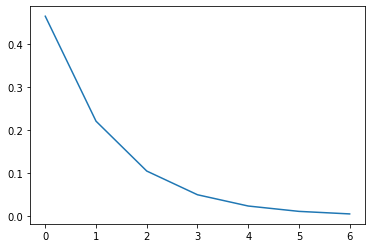

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.005368709120000003

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA',  # NY Stock Exchange (total)
           '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [(first, second) for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
        for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-03-14  16.312506  6.652284  16.312506  6.652284  16.312506  6.652284   
2022-03-15  16.921740  6.918109  16.921740  6.918109  16.921740  6.918109   
2022-03-16  18.269261  7.399436  18.269261  7.399436  18.269261  7.399436   
2022-03-17  18.954498  7.618823  18.954498  7.618823  18.954498  7.618823   
2022-03-18  19.790405  8.022104  19.790405  8.022104  19.790405  8.022104   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-03-14  16.312506  6.652284  16.312506  6.652284  
2022-03-15  16.921740  6.918109  16.921740  6.918109  
2022-03-16  18.269261  7.399436  18.269261  7.399436  
2022-03-17  18.954498  7.618823  18.954498  7.618823  
2022-03-18  19.790405  8.022104  19.790405  8.022104

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                              Close               \
        ^GSPC        ^IXIC         ^NYA       ^W5000       ^GSPC        ^IXIC   
0  785.770020  1249.290039  4373.189941  7468.569824  785.770020  1249.290039   
1  782.650024  1259.260010  4354.049805  7453.850098  782.650024  1259.260010   
2  784.099976  1254.069946  4364.839844  7468.069824  784.099976  1254.069946   
3  790.890015  1242.640015  4398.669922  7501.439941  790.890015  1242.640015   
4  789.070007  1248.060059  4392.430176  7497.319824  789.070007  1248.060059   

                                   High               ... DayToDayChange  \
          ^NYA       ^W5000       ^GSPC        ^IXIC  ...         ^W5000   
0  4373.189941  7468.569824  791.590027  1264.349976  ...            NaN   
1  4354.049805  7453.850098  786.289978  1262.660034  ...       0.998029   
2  4364.839844  7468.069824  786.440002  1267.280029  ...       1.001908   
3  4398.669922  7501.439941  791.010010  1251.069946  ...       1.004468   
4  4392.430176  7497.319824  798.109985  1253.869995  ...       0.999451   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1        0.998029      NaN            NaN            NaN             NaN   
2        1.001908      NaN            NaN            NaN             NaN   
3        1.004468      NaN            NaN            NaN             NaN   
4        0.999451      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

6288   2022-03-14
6289   2022-03-15
6290   2022-03-16
6291   2022-03-17
6292   2022-03-18
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                              Close  \
                 ^GSPC        ^IXIC         ^NYA       ^W5000       ^GSPC   
Date                                                                        
1997-03-19  785.770020  1249.290039  4373.189941  7468.569824  785.770020   
1997-03-20  782.650024  1259.260010  4354.049805  7453.850098  782.650024   
1997-03-21  784.099976  1254.069946  4364.839844  7468.069824  784.099976   
1997-03-24  790.890015  1242.640015  4398.669922  7501.439941  790.890015   
1997-03-25  789.070007  1248.060059  4392.430176  7497.319824  789.070007   

                                                         High               \
                  ^IXIC         ^NYA       ^W5000       ^GSPC        ^IXIC   
Date                                                                         
1997-03-19  1249.290039  4373.189941  7468.569824  791.590027  1264.349976   
1997-03-20  1259.260010  4354.049805  7453.850098  786.289978  1262.660034   
1997-03-21  1254.069946  4364.839844  7468.069824  786.440002  1267.280029   
1997-03-24  1242.640015  4398.669922  7501.439941  791.010010  1251.069946   
1997-03-25  1248.060059  4392.430176  7497.319824  798.109985  1253.869995   

            ... DayToDayChange OvernightChange LogValue IntradayChange  \
            ...         ^W5000          ^W5000    mine1          mine1   
Date        ...                                                          
1997-03-19  ...            NaN             NaN      NaN            NaN   
1997-03-20  ...       0.998029        0.998029      NaN            NaN   
1997-03-21  ...       1.001908        1.001908      NaN            NaN   
1997-03-24  ...       1.004468        1.004468      NaN            NaN   
1997-03-25  ...       0.999451        0.999451      NaN            NaN   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                    mine1           mine1    mine2          mine2   
Date                                                                
1997-03-19            NaN             NaN      NaN            NaN   
1997-03-20            NaN             NaN      NaN            NaN   
1997-03-21            NaN             NaN      NaN            NaN   
1997-03-24            NaN             NaN      NaN            NaN   
1997-03-25            NaN             NaN      NaN            NaN   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
1997-03-19            NaN             NaN  
1997-03-20            NaN             NaN  
1997-03-21            NaN             NaN  
1997-03-24            NaN             NaN  
1997-03-25            NaN             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)




----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.868896444512497
Refitting current best...
Current best ma returns: 4.151930816610369
Fraction Invested: 0.9607454308175882
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.151946729730559
Invested: 0.9607454308175882
New best: 4.151947289423308
Invested: 0.9607454308175882
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.868896444512497
Refitting current best...
Current best ew_ma returns: 4.109075305978204
Fraction Invested: 0.9771609152690672
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.109079016110566
Invested: 0.9771609152690672
New best: 4.109405681173063
Inv

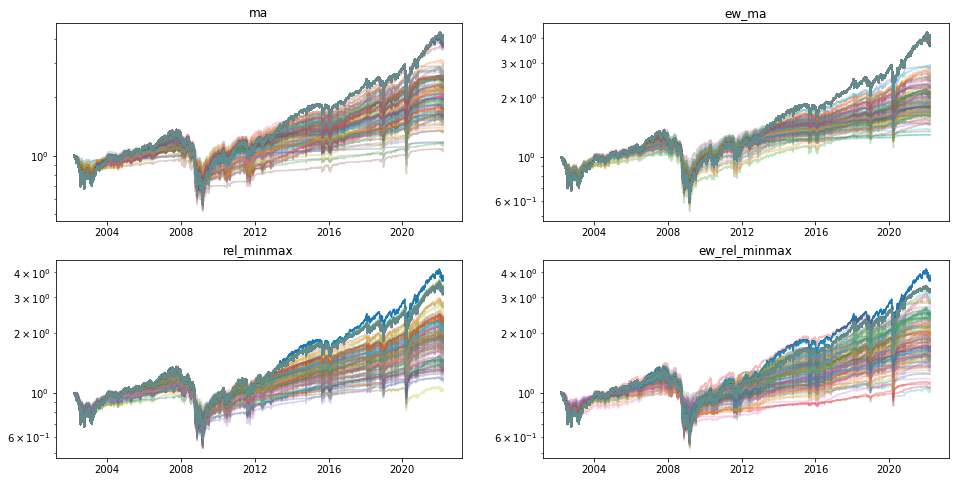

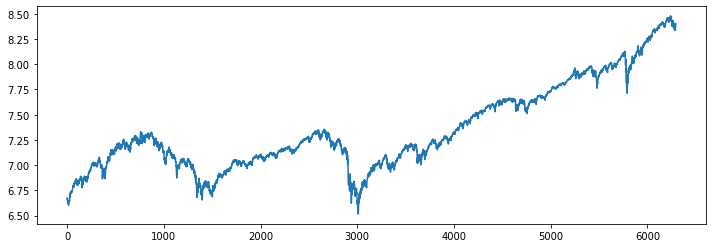

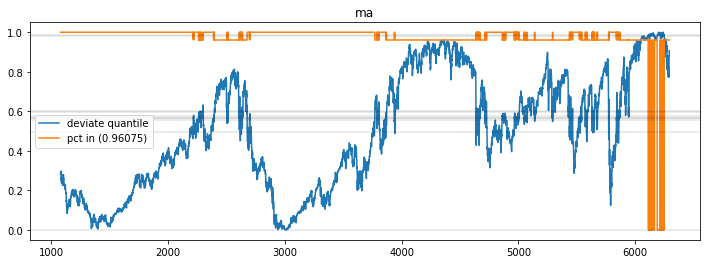

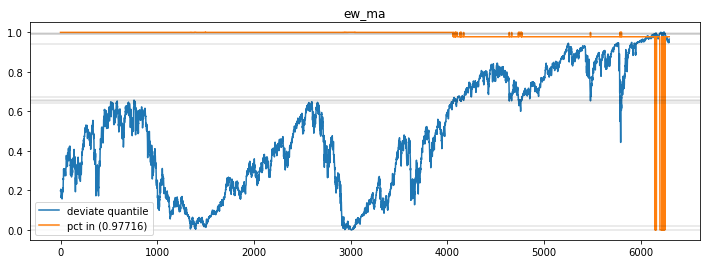

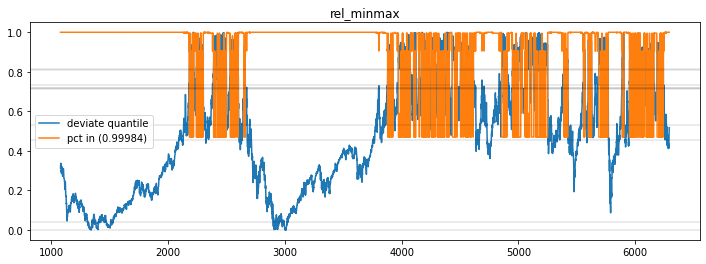

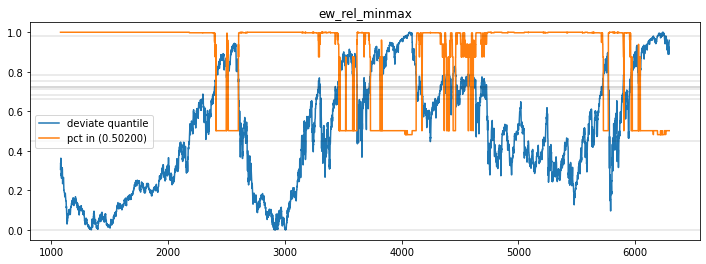

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.434511026029339
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.434511026029339
Refitting current best...
Current best ew_ma returns: 9.739712517753723
Fraction Invested: 0.9982041216772393
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 9.739712786688779
Invested: 0.9982041216772393
New best: 9.739712858098407
Invested: 0.9982041216772393
Round: 100


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 7.43451102

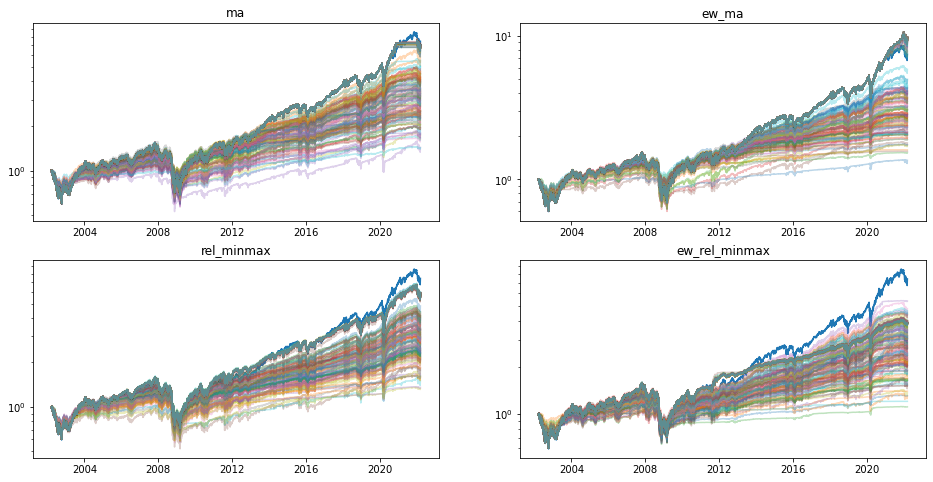

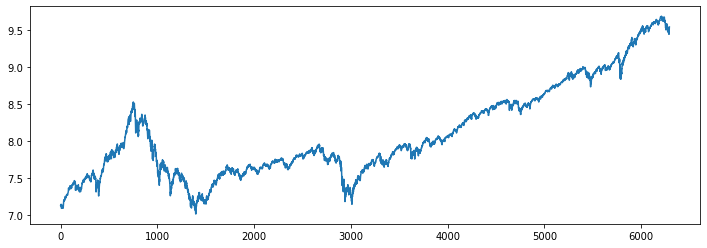

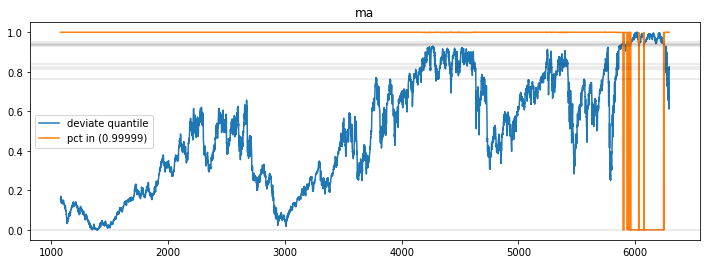

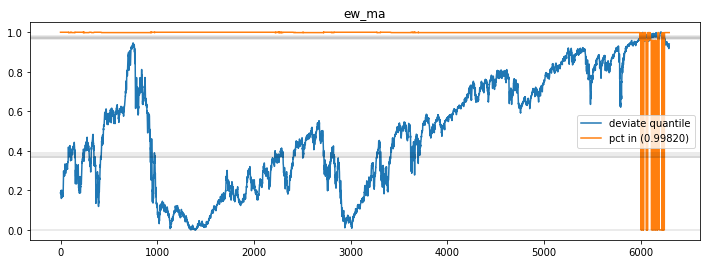

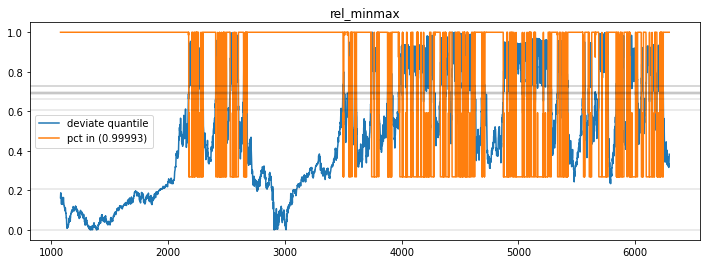

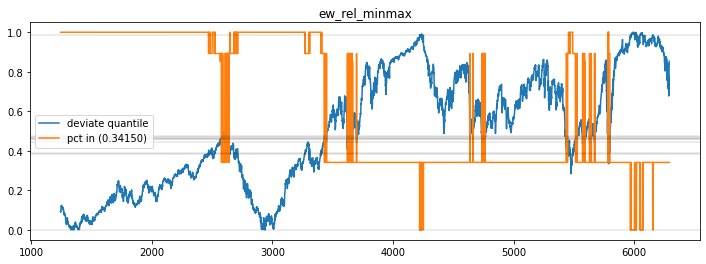

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.610621967223706
Refitting current best...
Current best ma returns: 3.3242411891960613
Fraction Invested: 0.9999999999999282
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.610621967223706
Refitting current best...
Current best ew_ma returns: 3.2848885257196483
Fraction Invested: 8.35442929321995e-05
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 3.28488897477516
Invested: 8.35442929321995e-05
New best: 3.285218563753027
Invested: 8.35442929321995e-05
New best: 3.2853999726904304
Invested: 8.35442929321995e-05

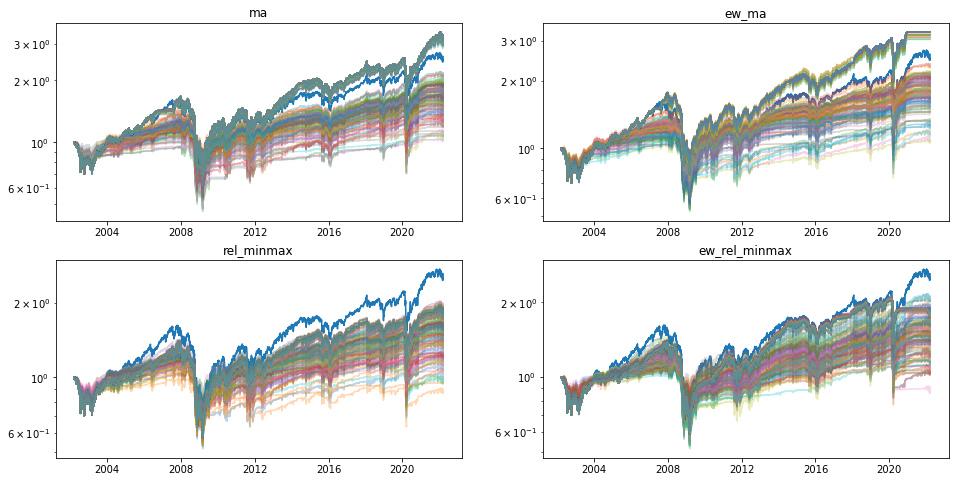

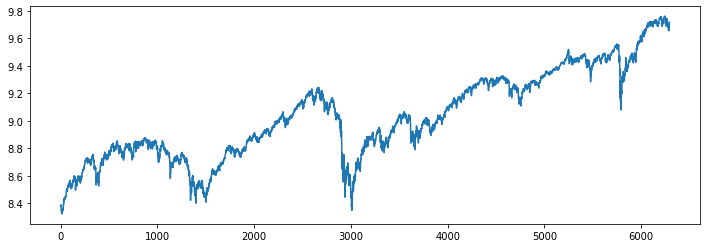

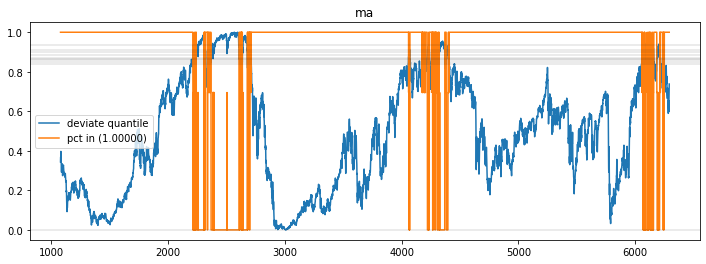

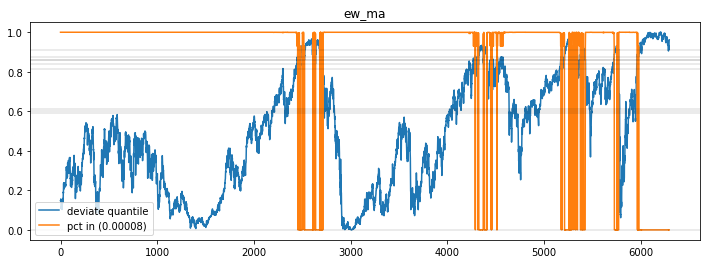

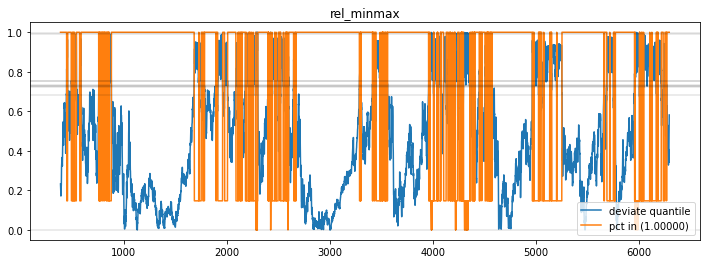

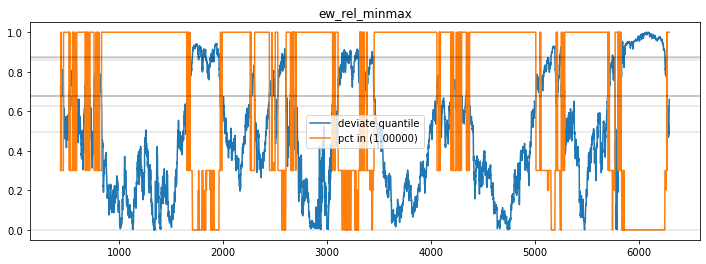

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.15849923181613
Refitting current best...
Current best ma returns: 4.498966348144964
Fraction Invested: 0.9942055815692069
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.498967712422935
Invested: 0.9942055815692069
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.15849923181613
Refitting current best...
Current best ew_ma returns: 4.664129601260041
Fraction Invested: 0.995766488023605
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 4.15849923

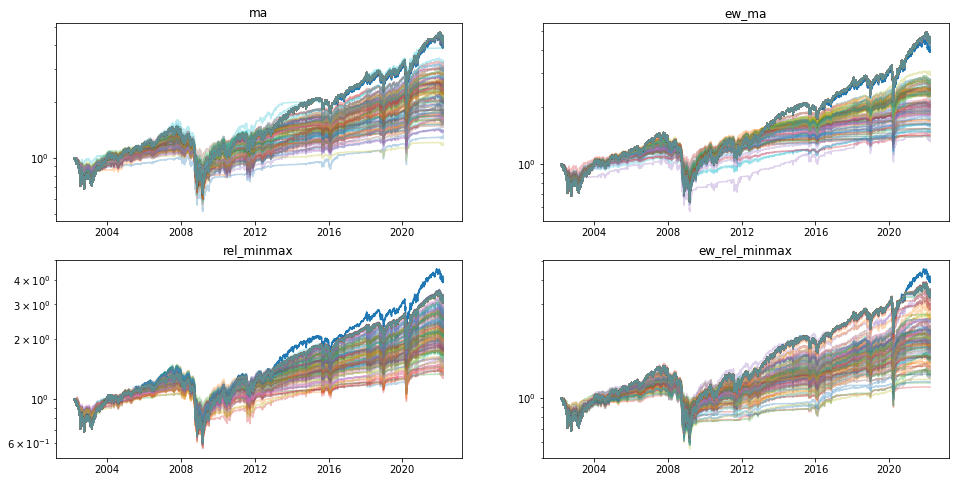

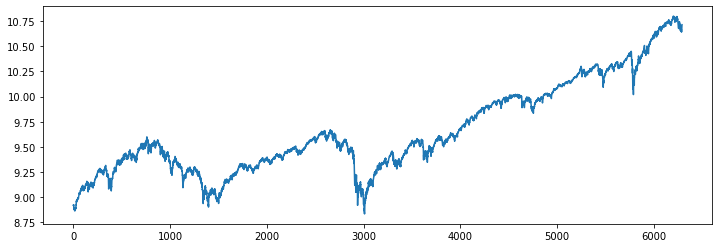

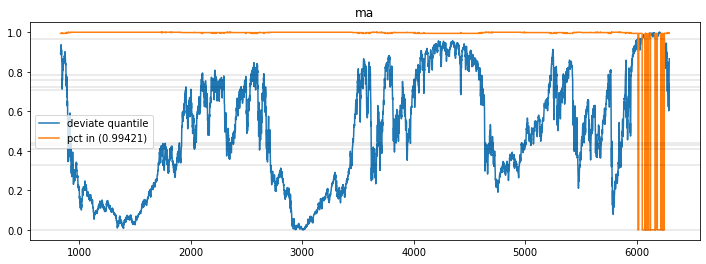

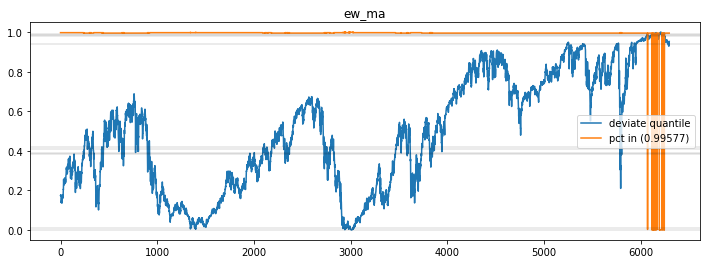

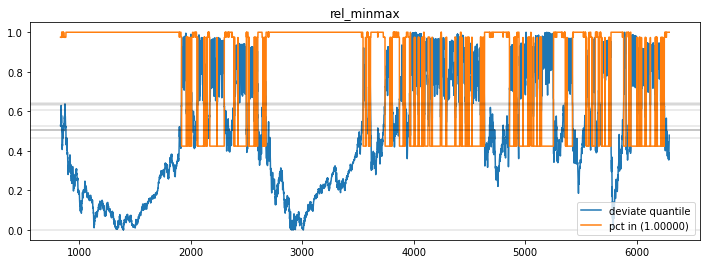

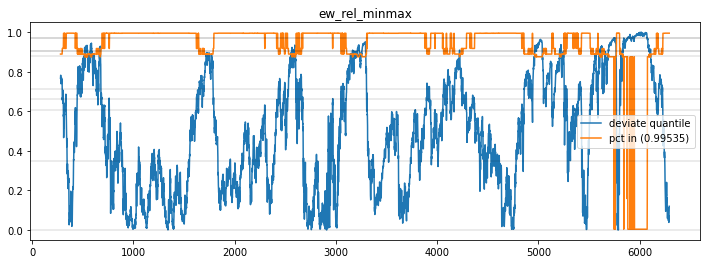

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.108949784948939
Refitting current best...
Current best ma returns: 13.33198984329084
Fraction Invested: 0.9999930399299342
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 13.332103262291032
Invested: 0.9999930399299342
New best: 13.33365534036665
Invested: 0.9999930399299342
New best: 13.333657776171673
Invested: 0.9999930399299342
New best: 13.334098301621918
Invested: 0.9999930399299342
New best: 13.33469732826231
Invested: 0.9999930399299342
New best: 13.334707066656915
Invested: 0.9999930399299342
New best: 13.33474765531862
Invested: 0.9999930399299342
New best: 13.35315633423023
Invested: 0.9999930399299342
New best: 13.353184601

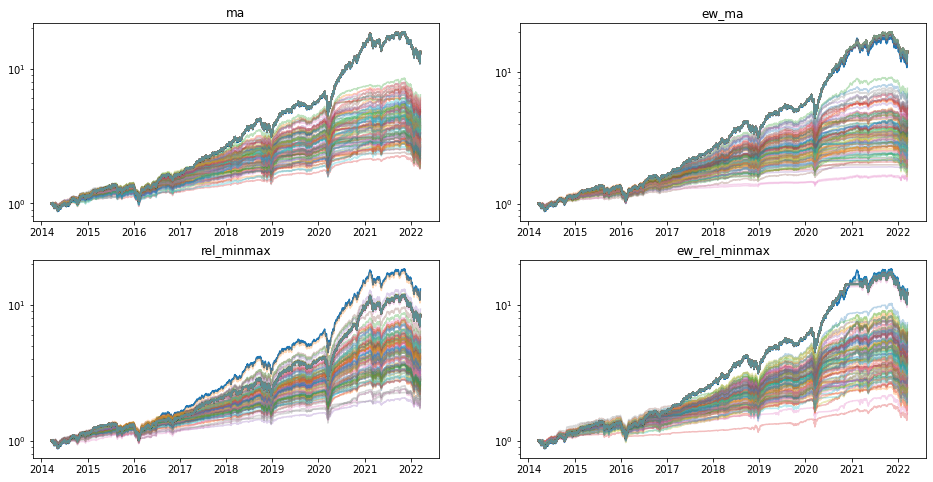

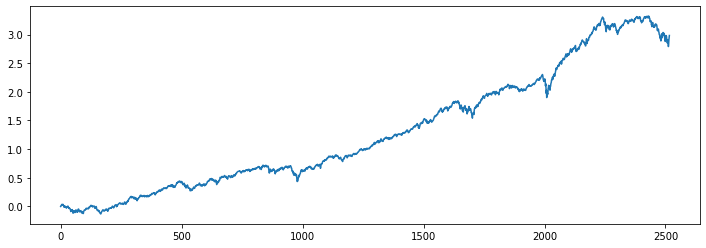

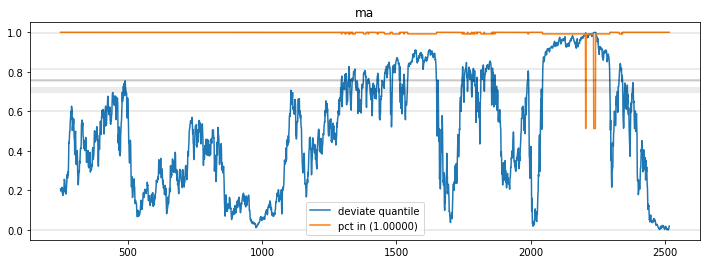

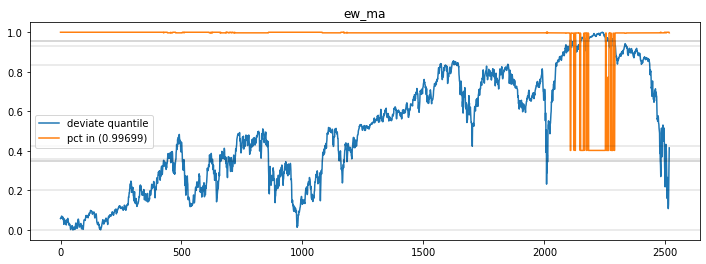

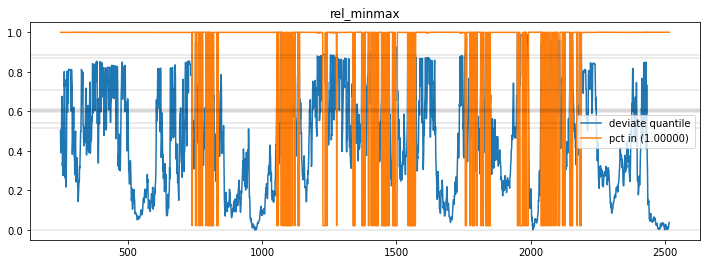

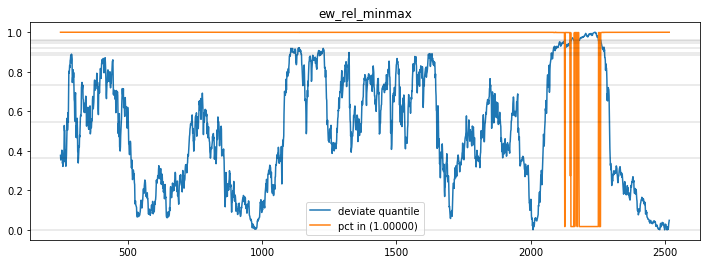

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.261068724038416
Refitting current best...
Current best ma returns: 6.5566264130962395
Fraction Invested: 1.0
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 6.557723701744524
Invested: 1.0
New best: 6.55884067299085
Invested: 1.0
New best: 6.582958515895762
Invested: 1.0
New best: 6.585380217339825
Invested: 1.0
New best: 6.587052332130455
Invested: 1.0
New best: 6.587071112209589
Invested: 1.0
New best: 6.587105778749131
Invested: 1.0
New best: 6.587112762925401
Invested: 1.0
New best: 6.587560745721404
Invested: 1.0
New best: 6.587648002063714
Invested: 1.0
Round: 100


Beginning ew_ma method...
----------------------------------------

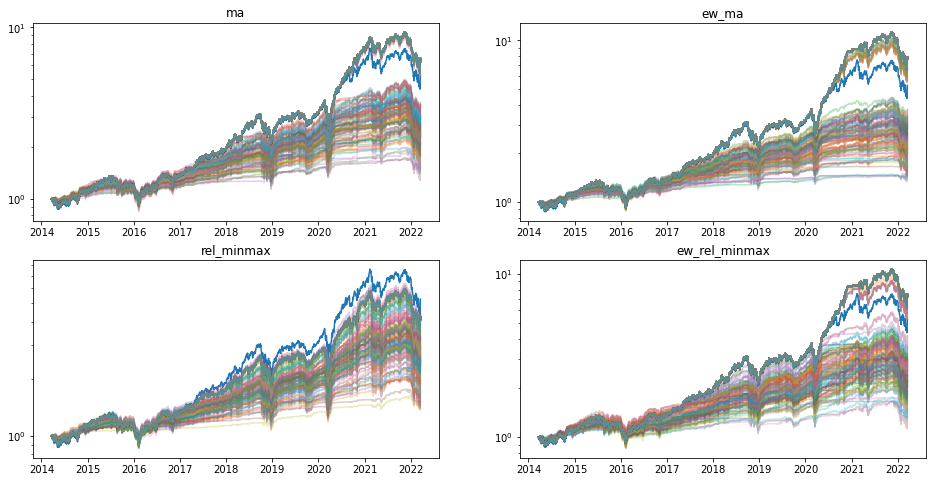

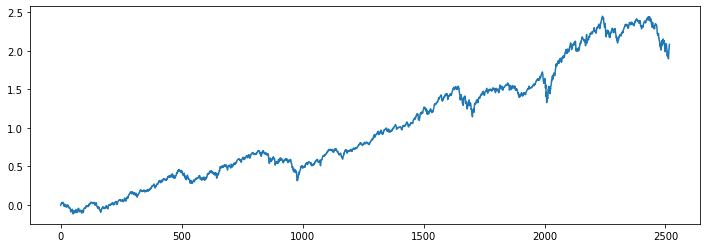

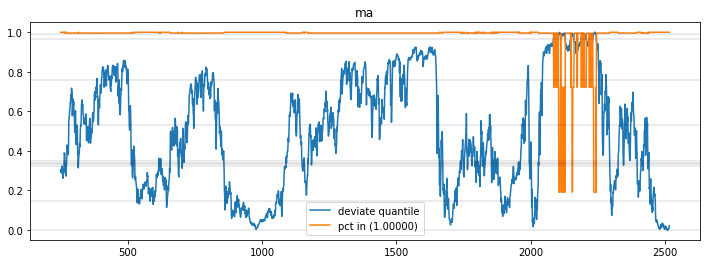

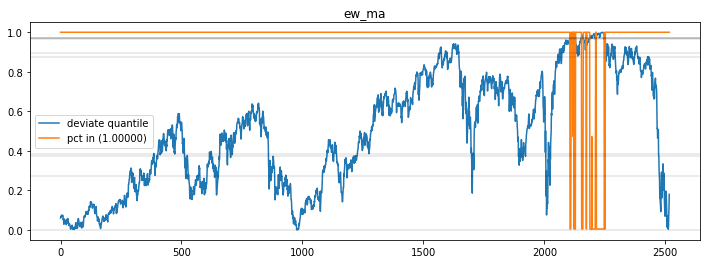

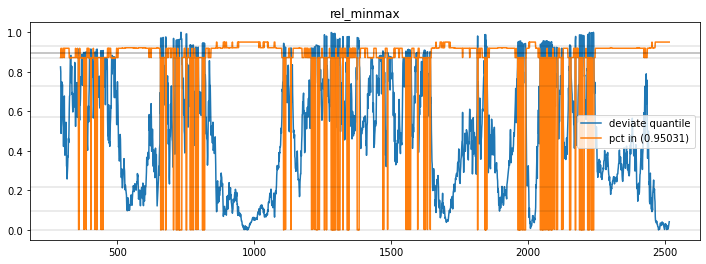

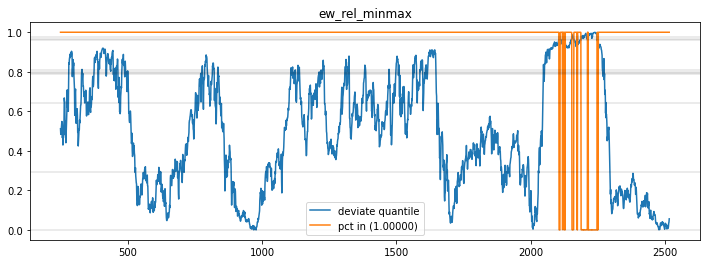

Saving mine2 params...


In [50]:
# [0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
#  0.00536871]
SD = 0.02376493 
N_RAND = 100
N_ADJ = 100

do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [51]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = best_return
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [52]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 4.151947289423308 (ma)
  0.96074543 in
time param: 1079
qs:
(0.0000 - 0.4966): 1.0000
(0.4966 - 0.5537): 1.0000
(0.5537 - 0.5648): 1.0000
(0.5648 - 0.5663): 1.0000
(0.5663 - 0.5772): 0.9633
(0.5772 - 0.5963): 0.9609
(0.5963 - 0.6019): 0.9609
(0.6019 - 0.9826): 0.9607
(0.9826 - 0.9860): 0.0014
(0.9860 - 1.0000): 0.0000

^IXIC:
  Best Return: 9.739712858098407 (ew_ma)
  0.99820412 in
time param: 1079
qs:
(0.0000 - 0.3686): 1.0000
(0.3686 - 0.3696): 1.0000
(0.3696 - 0.3765): 1.0000
(0.3765 - 0.3912): 0.9982
(0.3912 - 0.9654): 0.9982
(0.9654 - 0.9703): 0.9979
(0.9703 - 0.9714): 0.9602
(0.9714 - 0.9777): 0.9602
(0.9777 - 0.9797): 0.0004
(0.9797 - 1.0000): 0.0000

^NYA:
  Best Return: 3.3242411891960613 (ma)
  1.00000000 in
time param: 1079
qs:
(0.0000 - 0.8409): 1.0000
(0.8409 - 0.8515): 1.0000
(0.8515 - 0.8577): 1.0000
(0.8577 - 0.8664): 1.0000
(0.8664 - 0.8716): 0.6960
(0.8716 - 0.8827): 0.6950
(0.8827 - 0.9023): 0.6950
(0.9023 - 0.9094): 0.0001
(0.9094 - 0.9376): 0

{'^GSPC': 4.151947289423308,
 '^IXIC': 9.739712858098407,
 '^NYA': 3.3242411891960613,
 '^W5000': 4.664129601260041,
 'mine1': 14.438576706631299,
 'mine2': 7.896331195618837}

In [53]:
multipliers = {}
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]
    den = do_nothing_returns[stock]
    print(f'{stock}: {num} / {den}')
    multipliers[stock] = num / den
    
multipliers

^GSPC: 4.151947289423308 / 3.868896444512497
^IXIC: 9.739712858098407 / 7.434511026029339
^NYA: 3.3242411891960613 / 2.610621967223706
^W5000: 4.664129601260041 / 4.15849923181613
mine1: 14.438576706631299 / 13.108949784948939
mine2: 7.896331195618837 / 5.261068724038416


{'^GSPC': 1.0731606154287952,
 '^IXIC': 1.310067713128437,
 '^NYA': 1.2733521861578685,
 '^W5000': 1.1215896267517376,
 'mine1': 1.101428943088101,
 'mine2': 1.5008986975478213}

In [54]:
mults = np.array([multipliers[key] for key in batch + ['mine1', 'mine2']])
weights = mults / mults.sum()
weights

array([0.14540491, 0.17750398, 0.17252931, 0.15196666, 0.14923505,
       0.20336009])

In [55]:
!say qp is dunzo